In [1]:
pip install pymoo

In [2]:
import numpy as np
import pandas as pd

def matrix_decomp(x: np.ndarray, n: int, sr: int):
    """
    Decompose a 1D array into a 2D matrix with a specific pattern.
    """
    if x.ndim == 2:
        x = x[:, 0]

    x_i = np.full((n * sr,), np.nan, dtype=np.float32)
    pos = np.arange(0, n) * sr
    x_i[pos] = x
    ones = np.ones((1, x_i.shape[0]), dtype=np.float32)  # Row vector of ones
    x_i = x_i.reshape(-1, 1)  # Column vector
    X = np.dot(x_i, ones)  # Outer product-like behavior
    I = np.eye(n * sr)
    I[I == 0] = np.nan  # Replace non-diagonal elements with NaN
    X = X * I
    return X

def shift(x: np.ndarray, k=1):
    """
    Shift the array elements by k positions. Positive k shifts right, negative k shifts left.
    """
    if k > 0:
        y = np.concatenate([np.full((k,), np.nan), x])
        y = y[:len(x)]
    elif k < 0:
        k = abs(k)
        y = np.concatenate([x, np.full((k,), np.nan)])
        y = y[k:]
    else:
        y = x
    return y

def X_shift(X: np.ndarray, sr: int, p: np.ndarray):
    """
    Apply shifts to rows of a matrix based on the values in p.
    """
    # Pad the matrix to accommodate largest positive shift
    if np.max(p) > 0:
        X_out = np.pad(X.copy(), ((0, 0), (0, X.shape[0])), constant_values=np.nan)
    else:
        X_out = X.copy()

    # Shift the rows based on the values in p
    for i in range(1, int(X.shape[0] / sr)):
        x_r = X_out[i * sr, :]
        x_shift = shift(x_r, int(p[i]))
        X_out[i * sr, :] = x_shift

    return X_out

def fill_nan_with_last_value(x: np.ndarray):
    """
    Replace NaN values in an array with the last non-NaN value.
    """
    mask = np.isnan(x)

    last = x[0]
    for i in range(1, len(x)):
        if mask[i]:
            x[i] = last
        else:
            last = x[i]
    return x


In [43]:

class ShiftNetwork:
    def __init__(self, n, hidden_size, t, n_knots, opt_max=False):
        # Settings
        self.n = n
        self.hidden_size = hidden_size
        self.n_knots = n_knots
        self.t = t
        self.sr = 10
        self.opt_max = opt_max

        # Trainable parameters
        self.B = np.random.normal(0,5,n_knots)

        # Linear params
        self.A = np.random.normal(0,1)
        self.C = np.random.normal(0,1)

        #self.fc1_weights = np.random.normal(0,.1, hidden_size)[np.newaxis,:]
        #self.fc2_weights = np.random.normal(0,.1, hidden_size)
        #self.fc3_weights = np.random.normal(0,.1, hidden_size)
        #self.fc4_weights = np.random.normal(0,.1, hidden_size)

        #self.fc1_bias = np.random.normal(0,.1)
        #self.fc2_bias = np.random.normal(0,.1)
        #self.fc3_bias = np.random.normal(0,.1)
        #self.fc4_bias = np.random.normal(0,.1)

        # Utility parameters
        self.sigma = 0
        self.sigma_t = 0

    def matrix_decomp(self, x: np.ndarray, n: int, sr: int):
        """
        Decompose a 1D array into a 2D matrix with a specific pattern.
        """
        if x.ndim == 2:
            x = x[:, 0]

        x_i = np.full((n * sr,), np.nan, dtype=np.float32)
        pos = np.arange(0, n) * sr
        x_i[pos] = x
        ones = np.ones((1, x_i.shape[0]), dtype=np.float32)  # Row vector of ones
        x_i = x_i.reshape(-1, 1)  # Column vector
        X = np.dot(x_i, ones)  # Outer product-like behavior
        I = np.eye(n * sr)
        I[I == 0] = np.nan  # Replace non-diagonal elements with NaN
        X = X * I
        return X

    def shift(self, x: np.ndarray, k=1):
        """
        Shift the array elements by k positions. Positive k shifts right, negative k shifts left.
        """
        if k > 0:
            y = np.concatenate([np.full((k,), np.nan), x])
            y = y[:len(x)]
        elif k < 0:
            k = abs(k)
            y = np.concatenate([x, np.full((k,), np.nan)])
            y = y[k:]
        else:
            y = x
        return y

    def X_shift(self, X: np.ndarray, sr: int, p: np.ndarray):
        """
        Apply shifts to rows of a matrix based on the values in p.
        """
        # Pad the matrix to accommodate largest positive shift
        if np.max(p) > 0:
            X_out = np.pad(X.copy(), ((0, 0), (0, X.shape[0])), constant_values=np.nan)
        else:
            X_out = X.copy()

        # Shift the rows based on the values in p
        for i in range(1, int(X.shape[0] / sr)):
            x_r = X_out[i * sr, :]
            x_shift = shift(x_r, int(p[i]))
            X_out[i * sr, :] = x_shift

        return X_out

    def set_opt_max(self, is_max):
        self.opt_max = is_max

    def basis_matrix(self):
        x = np.arange(1, self.t + 1)  # Sample x values
        self.k_values = np.arange(0, self.n_knots) * (self.t / self.n_knots)
        self.rw_interval = np.diff(self.k_values)[0]
        X = self.create_basis(x, self.k_values)
        return X

    def piecewise_linear(self, x, k):
        y = x - k
        y[y < 0] = 0
        y[x < k] = 0
        return y

    def create_basis(self, x, k):
        num_x = len(x)
        num_k = len(k)
        b = np.zeros((num_x, num_k))
        for i in range(num_k):
            b[:, i] = self.piecewise_linear(x, k[i])
        return b

    def fill_nan_with_last_value(self, x):
        mask = np.isnan(x)
        last = x[0]
        for i in range(1, len(x)):
            if mask[i]:
                x[i] = last
            else:
                last = x[i]
        return x

    def conditional_posterior(self, d, u, sd, n_steps):
        u = d / n_steps
        sd = np.sqrt((sd**2) * (n_steps - 1) / n_steps)
        return u, sd

    def px_z(self, u1, u2, sd1, sd2):
        alpha = np.sqrt(1 / (2 * sd2**2) + 1 / (2 * sd1**2))
        alpha_beta = u2 / (2 * sd2**2) + u1 / (2 * sd1**2)
        gamma = (u2**2) / (2 * sd2**2) + (u1**2) / (2 * sd1**2)
        beta = alpha_beta / alpha
        p1 = 1 / (2 * sd1 * sd2 * alpha * np.sqrt(np.pi))
        p2 = np.exp(-gamma + beta**2)
        return p1 * p2

    def reverse_softplus(self, x):
        if x > -10:
            return -np.log(1 + np.exp(-x))
        else:
            return x

    def expected_likelihood(self, d, u, sd, n_steps):
        post_u, post_sd = self.conditional_posterior(d, u, sd, n_steps)
        el = np.log(self.px_z(0, post_u, sd, post_sd))
        return self.reverse_softplus(el * n_steps)

    def terror_likelihood(self, k_values, sd, RW_width, p):
        total_likelihood = 0
        k_values = np.append(k_values, len(p) - 1)
        for i in range(1, len(k_values)):
            x1 = k_values[i - 1]
            x2 = k_values[i]
            y1 = p[int(x1)]
            y2 = p[int(x2)]
            d = y2 - y1
            el = self.expected_likelihood(d, 0, sd, RW_width)
            total_likelihood += el
        return total_likelihood

    def forward(self, x, basis_X):

        # By reversing the series we can fix the most recent value in place
        #x = np.flip(x)

        # Clamp the B parameters
        B = np.clip(self.B, -4, 4)

        # zero gradient after each warp
        G = np.zeros(len(B))
        G[0] = B[0]
        for i in range(1, len(B)):
          G[i] = -1*np.sum(G[:(i)]) + B[i]
        p = np.matmul(basis_X, G)
        #p = np.flip(p)

        X = self.matrix_decomp(x, n, sr)
        # Complete shift
        #X_s = self.X_shift(X, sr, np.repeat(self.S, p.shape[0]))
        # Warp
        X_s = self.X_shift(X, sr, p)
        x_s = np.nanmedian(X_s, axis=0)
        x_out = fill_nan_with_last_value(x_s)
        x_out = x_out[::sr]
        x_out = x_out[:len(x)]

        # Apply fully connected layers
        #h1 = np.maximum(0, np.dot(x_shift, self.fc1_weights) + self.fc1_bias)  # ReLU
        #h2 = np.maximum(0, np.dot(h1, self.fc2_weights) + self.fc2_bias)  # ReLU
        #h3 = np.maximum(0, np.dot(h2, self.fc3_weights) + self.fc3_bias)  # ReLU
        #y = np.dot(h3, self.fc4_weights) + self.fc4_bias
        # Linear transformation
        #x_out = np.flip(x_out)

        y = self.A*(x_out) + self.C

        return y.flatten(), p

    def predict_realisations(self, x, n, draws=True):
        realisations = []
        for _ in range(n):
            y = self.predict(x, draws=draws)
            realisations.append(y)
        return realisations

    def predict(self, x, draws=False):

        B = np.clip(self.B, -4, 4)
        # zero gradient after each warp
        G = np.zeros(len(B))
        G[0] = B[0]
        for i in range(1, len(B)):
          G[i] = -1*np.sum(G[:(i)]) + B[i]

        if not draws:
            p = np.zeros_like(G)
            #p = np.flip(p)
            #x = np.flip(x)
        else:
            rw = np.cumsum(
                np.random.normal(0, np.exp(self.sigma_t) * self.sr, size=x.shape[0] * self.sr)
            )
            p = rw[::self.sr]

        X = self.matrix_decomp(x, x.shape[0], sr)
        X_s = self.X_shift(X, sr, p)
        x_s = np.nanmedian(X_s, axis=0)
        #x_out = fill_nan_with_last_value(x_s)
        x_out = np.array(pd.Series(x_s).interpolate(method="linear"))
        x_out = x_out[::sr]
        x_out = x_out[:len(x)]


        #if not draws:
          #x_out = np.flip(x_out)

        y = self.A*(x_out) + self.C
        return y.flatten()

    def log_likelihood(self, y_pred, y, p):
        sigma = np.exp(self.sigma)
        sigma_t = np.exp(self.sigma_t)

        # Error likelihood
        ll = np.sum(-0.5 * np.log(2 * np.pi * sigma**2) - (y_pred - y)**2 / (2 * sigma**2))

        # Random walk shift likelihood
        tl = self.terror_likelihood(self.k_values, sigma_t, self.rw_interval, p)

        # Maximize or minimize based on optimization
        return [-ll, -tl] #+ tl if self.opt_max else -(ll + tl)


In [4]:
def generate_example_waves(n):
    np.random.seed(12)
    x = np.arange(1,n+1)/100
    x = 2*np.pi*x
    y1 = np.sin(x)
    y2 = np.sin(x) + np.random.normal(0, 0.5, size=n)
    return x, y1, y2


def generate_sample_perturbations(scale, n, type="gaussian", truncate=False, sr=10):
    perturbations = (np.random.normal(loc=0, scale=(scale - 1), size=n))
    perturbations = perturbations.astype("int")
    if truncate is True:
        perturbations[perturbations <= -1*sr] = -1*sr
    p_cum = np.cumsum(perturbations)
    return perturbations, p_cum

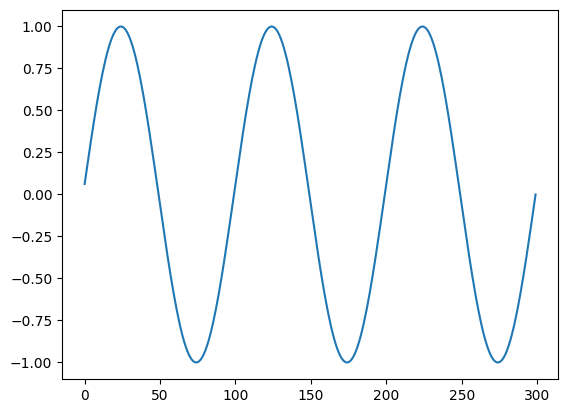

In [5]:
import matplotlib.pyplot as plt
# Create sample waves
n=300
sr=10
z, x, y1 = generate_example_waves(n)
plt.plot(x)

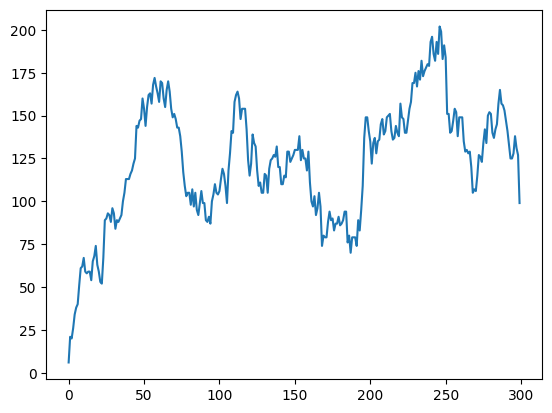

In [6]:
# Create perturbation profile
p_step, p = generate_sample_perturbations(10, n, truncate=False, sr=sr)
plt.plot(p)

In [7]:

X = matrix_decomp(x, n, sr)


X_s = X_shift(X, sr, p)


In [8]:
x_s = np.nanmedian(X_s, axis=0)
x_out = fill_nan_with_last_value(x_s)
y = x_out[::sr]
y = y[:len(x)]
y = y + np.random.normal(0,0.2, size=len(y))

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


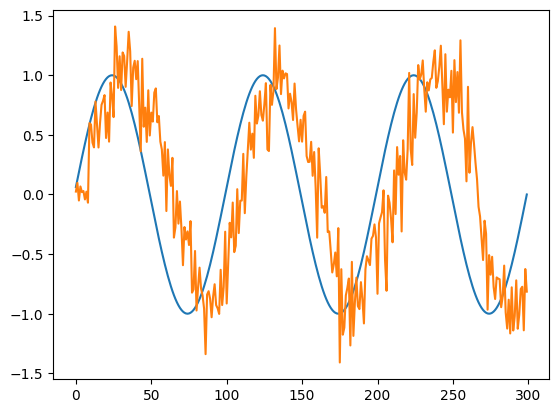

In [9]:
plt.plot(x)
plt.plot(y)


In [10]:
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.problem import ElementwiseProblem

In [44]:
class WarpMulti(ElementwiseProblem):

    def __init__(self, x_dat, y_dat, pop_size=40):
        super().__init__(
            n_var=12,  # Number of decision variables
            n_obj=2,      # Number of objectives
            n_constr=0,   # No constraints
            xl=[-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5],     # Lower bounds for variables
            xu=[5,5,5,5,5,5,5,5,5,5,0,0]       # Upper bounds for variables
        )
        self.x_dat = x_dat
        self.y_dat = y_dat
        self.pop_size = pop_size


    def _evaluate(self, x, out, **kwargs):

        A = x[0]
        B = x[1:9]
        C = x[9]
        sigma = x[10]
        sigma_t = x[11]

        x_dat = self.x_dat
        y_dat = self.y_dat

        model = ShiftNetwork(n=1, hidden_size=5, t=n, n_knots=8, opt_max=True)
        basis_X = model.basis_matrix()
        model.A = A
        model.B = B
        model.C = C
        model.sigma = sigma
        model.sigma_t = sigma_t

        y_p, p = model.forward(x_dat, basis_X)
        ll = model.log_likelihood(y_p, y_dat, p)
        f1 = ll[0]
        f2 = ll[1]

        out["F"] = [f1, f2]



In [45]:
# Initialize the problem
pop_size = 40
problem = WarpMulti(x_dat=x, y_dat=y, pop_size=pop_size)
algorithm = NSGA2(
    pop_size=pop_size,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
# Termination criteria: Stop after 500 generations
termination = get_termination("n_gen", 250)

In [28]:
# Run optimization
result = minimize(
    problem,
    algorithm,
    termination,
    seed=1,
    verbose=True,
)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
<ipython-input-25-343821a698f3>:139: RuntimeWarning: divide by zero encountered in log
  el = np.log(self.px_z(0, post_u, sd, post_sd))
/usr/local/lib/python3.10/dist-packages/pymoo/operators/survival/rank_and_crowding/metrics.py:97: RuntimeWarning: invalid value encountered in subtract
  dist = np.row_stack([F, np.full(n_obj, np.inf)]) - np.row_stack([np.full(n_obj, -np.inf), F])
/usr/local/lib/python3.10/dist-packages/pymoo/operators/survival/rank_and_crowding/metrics.py:105: RuntimeWarning: invalid value encountered in divide
  dist_to_last, dist_to_next = dist_to_last[:-1] / norm, dist_to_next[1:] / norm


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      5 |             - |             -


/usr/local/lib/python3.10/dist-packages/pymoo/termination/ftol.py:14: RuntimeWarning: invalid value encountered in subtract
  return np.max(np.abs((a - b) / norm))
/usr/local/lib/python3.10/dist-packages/pymoo/util/normalization.py:86: RuntimeWarning: invalid value encountered in divide
  N[..., neither_nan] = (X[..., neither_nan] - xl[neither_nan]) / (xu[neither_nan] - xl[neither_nan])


     2 |       50 |      6 |           nan |             f
     3 |       60 |      6 |           nan |             f
     4 |       70 |      2 |           nan |             f
     5 |       80 |      3 |  0.3748234212 |         ideal
     6 |       90 |      3 |           nan |             f
     7 |      100 |      3 |           nan |             f
     8 |      110 |      3 |  0.0101481703 |         ideal
     9 |      120 |      4 |           nan |             f
    10 |      130 |      3 |  0.0619367190 |         ideal
    11 |      140 |      4 |  0.0235731047 |         ideal
    12 |      150 |      6 |  0.0233572754 |         ideal
    13 |      160 |      6 |  0.000000E+00 |             f
    14 |      170 |      6 |  0.000000E+00 |             f
    15 |      180 |      6 |  0.0829078920 |         ideal
    16 |      190 |      8 |  0.0236199832 |             f
    17 |      200 |      8 |  0.0487198120 |             f
    18 |      210 |      6 |  0.0028942560 |         ide

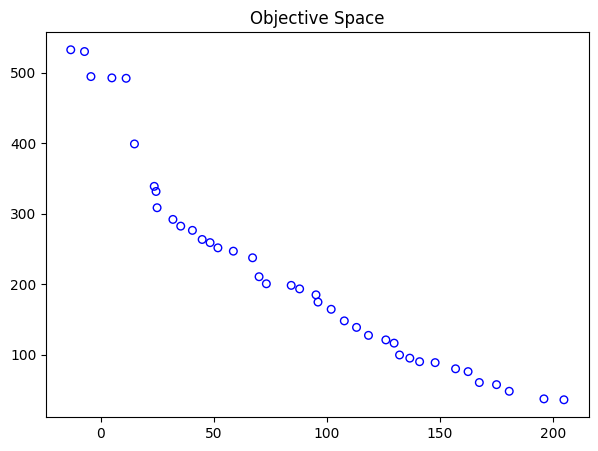

In [34]:
plt.figure(figsize=(7, 5))
plt.scatter(result.F[:, 0], result.F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [35]:
sel = np.argmin(result.F[:,0])


In [36]:
A = result.X[sel,:][0]
B = result.X[sel,1:9]
C = result.X[sel,9]

model = ShiftNetwork(n=1, hidden_size=5, t=n, n_knots=8, opt_max=True)
basis_X = model.basis_matrix()
model.A = A
model.B = B
model.C = C
y_fit, p_fit = model.forward(x, basis_X)
ll = model.log_likelihood(y_fit, y, p_fit)

print(ll)

[283.71669407633806, 506.8158229257141]


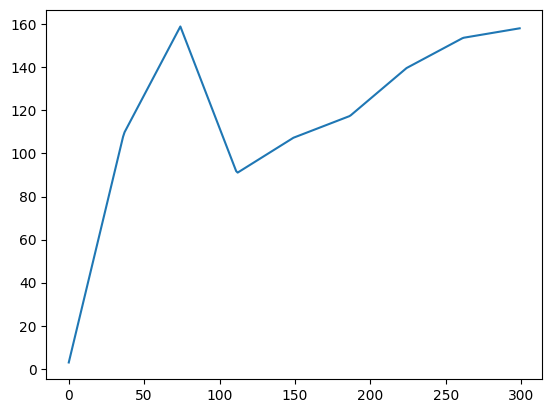

In [37]:
plt.plot(p_fit)

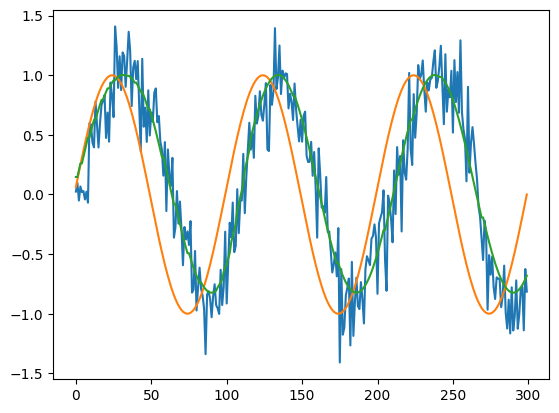

In [38]:
plt.plot(y)
plt.plot(x)
plt.plot(y_fit)

In [39]:
# Predict realisations
rw_predictions = model.predict_realisations(x[:60], 1000,draws=True)

In [40]:
#Stack the paths into a single array and plot
all_paths = np.stack(rw_predictions)

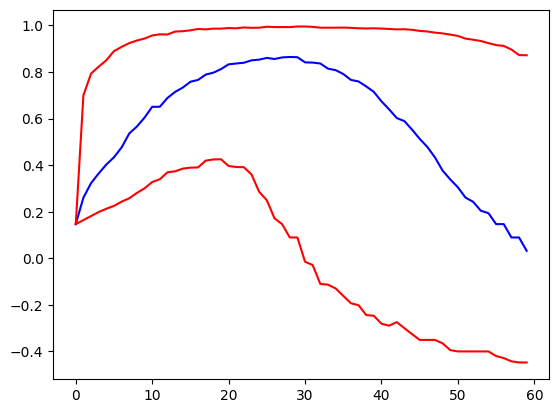

In [41]:

# Calculate the quantiles
q10 = np.quantile(all_paths, axis=0, q=0.10)
q90 = np.quantile(all_paths, axis=0, q=0.90)
q50 = np.quantile(all_paths, axis=0, q=0.50)
# Plot the quantiles
plt.plot(q50, color="blue")
plt.plot(q10, color="red")
plt.plot(q90, color="red")
plt.show()